In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import pandas as pd
import seaborn as sns

from datetime import datetime
from pathlib import Path

from gensim.models.doc2vec import Doc2Vec
from hdbscan import HDBSCAN
from sklearn.cluster import KMeans, MeanShift
from sklearn.metrics import silhouette_score

plt.rcParams['figure.dpi'] = 100
plt.rcParams["figure.autolayout"] = True

In [2]:
data_dir = Path(Path.cwd().parent, 'data/interim')
models_dir = Path(Path.cwd().parent, 'models')
evals_dir = Path(data_dir, 'evals_5')
labels_dir = Path(data_dir, 'labels_4')
models_dir = Path(Path.cwd().parent, 'models')
datasets_order = {
    'chains_eq_2': 0,
    'chains_eq_3': 1,
    'chains_ge_4_lt_10': 2,
    'chains_ge_10': 3}

datasets_names = {
    'chains_eq_2': r'CL $= 2$',
    'chains_eq_3': r'CL $= 3$',
    'chains_ge_4_lt_10': r'10 $>$ CL $\geq$ 4',
    'chains_ge_10': r'CL $\geq$ 10'}

sizes = {}
for path in Path(models_dir).glob('d2v*.model'):
    size = len(Doc2Vec.load(str(path)).dv.vectors)
    name = '_'.join(path.stem.split('_')[1:])
    sizes[name] = size
    
score_names = [
    f'Worse{" "*12}Silhouette{" "*12}Better',
    f'Worse{" "*8}Calinski-Harabasz{" "*8}Better',
    f'Better{" "*10}Davies-Bouldin{" "*10}Worse',
    f'Stable{" "*16}Entropy{" "*16}Unstable'
]

In [3]:
df_kmeans = pd.concat([pd.read_csv(path) for path in evals_dir.glob('eval_km*.csv')], ignore_index=True)
df_kmeans['dimensions'] = df_kmeans['dataset'].apply(lambda s: s.split('_')[-1])
df_kmeans['dataset'] = df_kmeans['dataset'].apply(lambda s: '_'.join(s.split('_')[:-1]))
df_kmeans['order'] = df_kmeans['dataset'].map(datasets_order)
df_kmeans['name'] = df_kmeans['dataset'].map(datasets_names)
df_kmeans = df_kmeans.sort_values('order')
df_kmeans['k_noise'] = df_kmeans['n_clusters'].astype(int)
df_kmeans['method'] = 'KMeans'

df_dbscan = pd.concat([pd.read_csv(path) for path in evals_dir.glob('eval_dbscan*.csv')], ignore_index=True)
df_dbscan['size'] = df_dbscan['dataset'].map(sizes)
df_dbscan['prop_noise'] = df_dbscan['n_noise']/df_dbscan['size']
df_dbscan['dimensions'] = df_dbscan['dataset'].apply(lambda s: s.split('_')[-1])
df_dbscan['dataset'] = df_dbscan['dataset'].apply(lambda s: '_'.join(s.split('_')[:-1]))
df_dbscan['order'] = df_dbscan['dataset'].map(datasets_order)
df_dbscan['name'] = df_dbscan['dataset'].map(datasets_names)
df_dbscan = df_dbscan.sort_values('order')
df_dbscan['k_noise'] = df_dbscan.apply(lambda x: f"{x['n_clusters']} ({x['prop_noise']:.3f})", axis=1)
df_dbscan['method'] = 'DBSCAN'
df_dbscan = df_dbscan.loc[df_dbscan['epsilon'] != 0.2,:]

df_hdbscan = pd.concat([pd.read_csv(path) for path in evals_dir.glob('*_hdbscan*.csv')], ignore_index=True)
df_hdbscan['size'] = df_hdbscan['dataset'].map(sizes)
df_hdbscan['prop_noise'] = df_hdbscan['n_noise']/df_hdbscan['size']
df_hdbscan['dimensions'] = df_hdbscan['dataset'].apply(lambda s: s.split('_')[-1])
df_hdbscan['dataset'] = df_hdbscan['dataset'].apply(lambda s: '_'.join(s.split('_')[:-1]))
df_hdbscan['order'] = df_hdbscan['dataset'].map(datasets_order)
df_hdbscan['name'] = df_hdbscan['dataset'].map(datasets_names)
df_hdbscan = df_hdbscan.sort_values('order')
df_hdbscan['k_noise'] = df_hdbscan.apply(lambda x: f"{x['n_clusters']} ({x['prop_noise']:.3f})", axis=1)
df_hdbscan['method'] = 'HDBSCAN'
datasets = df_dbscan.sort_values(by='order')['dataset'].unique()

scores = ['sl_score', 'ch_score', 'db_score', 'entropy']

# KMeans

In [4]:
df_kmeans

distance       dataset  n_clusters  sl_score    ch_score  db_score  \
56  euclidean   chains_eq_2          20 -0.003933  104.039509  2.850879   
54  euclidean   chains_eq_2          18 -0.021653  147.016322  3.735404   
53  euclidean   chains_eq_2          17  0.031314  110.142526  2.976660   
52  euclidean   chains_eq_2          16 -0.010891  142.572212  3.423158   
51  euclidean   chains_eq_2          15 -0.008288  146.347738  3.359940   
..        ...           ...         ...       ...         ...       ...   
62  euclidean  chains_ge_10          11 -0.059547   58.854291  4.463261   
63  euclidean  chains_ge_10          12 -0.033005   53.927707  4.165994   
65  euclidean  chains_ge_10          14 -0.081436   51.317712  4.109299   
57  euclidean  chains_ge_10           6  0.013319   79.810647  4.949658   
0   euclidean  chains_ge_10           6 -0.008875   35.248970  5.142306   

     entropy dimensions  order          name  k_noise  method  
56  1.602286        300      0      CL $= 2$       20  KMeans  
54  1.933523        300      0      CL $= 2$       18  KMeans  
53  1.537981        300      0      CL $= 2$       17  KMeans  
52  1.660034        300      0      CL $= 2$       16  KMeans  
51  1.602283        300      0      CL $= 2$       15  KMeans  
..       ...        ...    ...           ...      ...     ...  
62  2.298521         50      3  CL $\geq$ 10       11  KMeans  
63  2.278246         50      3  CL $\geq$ 10       12  KMeans  
65  2.477456         50      3  CL $\geq$ 10       14  KMeans  
57  1.645276         50      3  CL $\geq$ 10        6  KMeans  
0   1.341525        300      3  CL $\geq$ 10        6  KMeans  

[152 rows x 12 columns]

In [5]:
iter_dataset = iter(df_kmeans.sort_values(by='order')['dataset'].unique())

chains_eq_2


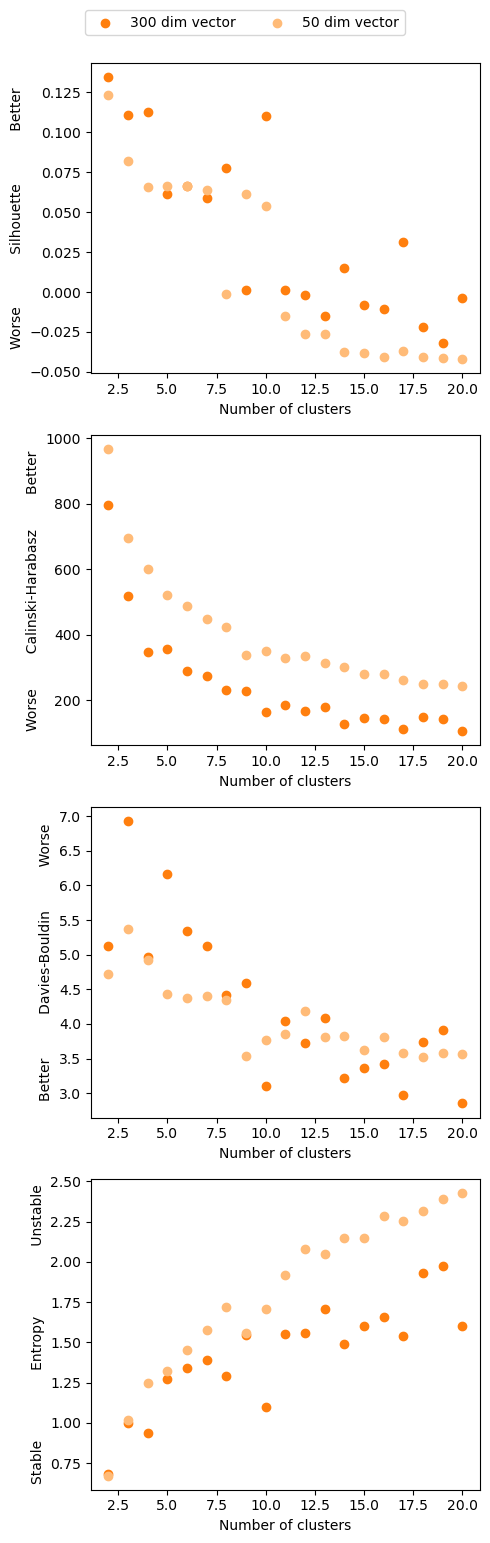

In [6]:
dat = next(iter_dataset)
print(dat)
params = ['n_clusters']
parnam = {params[0]: 'Number of clusters'}
ncols = len(params)
nrows = len(scores)
cmap = mpl.colormaps['tab20']
df_subset = df_kmeans.dropna(how='all', subset=scores)

fig, axes = plt.subplots(nrows, ncols, figsize=(5,15))
col = 0
for row in range(nrows):
# for col in range(ncols): 
    X = df_subset.loc[df_subset['dataset']==dat,:].sort_values(params[col])
    x = X.loc[(X['dimensions']=='300') & (X['distance']=='euclidean'),:]
    axes[row].scatter(data=x, x=params[col], y=scores[row], label=f'300 dim vector', color=cmap.colors[2])
    x = X.loc[(X['dimensions']=='50') & (X['distance']=='euclidean'),:]
    axes[row].scatter(data=x, x=params[col], y=scores[row], label=f'50 dim vector', color=cmap.colors[3])
    # x = X.loc[(X['dimensions']=='300') & (X['distance']=='cosine'),:]
    # axes[row].scatter(data=x, x=params[col], y=scores[row], label=f'cosine, 300', color=cmap.colors[0], marker='^', alpha=0.7)
    # x = X.loc[(X['dimensions']=='50') & (X['distance']=='cosine'),:]
    # axes[row].scatter(data=x, x=params[col], y=scores[row], label=f'cosine, 50', color=cmap.colors[1], marker='^', alpha=0.7)
    # x = X.loc[(X['dimensions']=='300') & (X['distance']=='wmd'),:]
    # axes[row].scatter(data=x, x=params[col], y=scores[row], label=f'wmd, 300', color=cmap.colors[4], marker='s', alpha=0.7)
    # x = X.loc[(X['dimensions']=='50') & (X['distance']=='wmd'),:]
    # axes[row].scatter(data=x, x=params[col], y=scores[row], label=f'wmd, 50', color=cmap.colors[5], marker='s', alpha=0.7)
    # x = X.loc[(X['dimensions']=='300') & (X['distance']=='l2'),:]
    # axes[row].scatter(data=x, x=params[col], y=scores[row], label=f'l2, 30', color=cmap.colors[6], marker='+', alpha=0.7)
    # x = X.loc[(X['dimensions']=='50') & (X['distance']=='l2'),:]
    # axes[row].scatter(data=x, x=params[col], y=scores[row], label=f'l2, 50', color=cmap.colors[7], marker='+', alpha=0.7)
    # axes[row].set_title(fr'{datasets_names[datasets[col]]}')
    axes[row].set_xlabel(parnam[params[col]])
    axes[row].set_ylabel(score_names[row])
    # if params[col] not in params[1:]:
    #     axes[row].set_xscale('log')
    handles, labels = axes[row].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5,1.03), ncol=2)
fig.savefig(Path(f'../img/scores_kmeans_{dat}.png'), bbox_inches='tight')
plt.show()

chains_eq_3


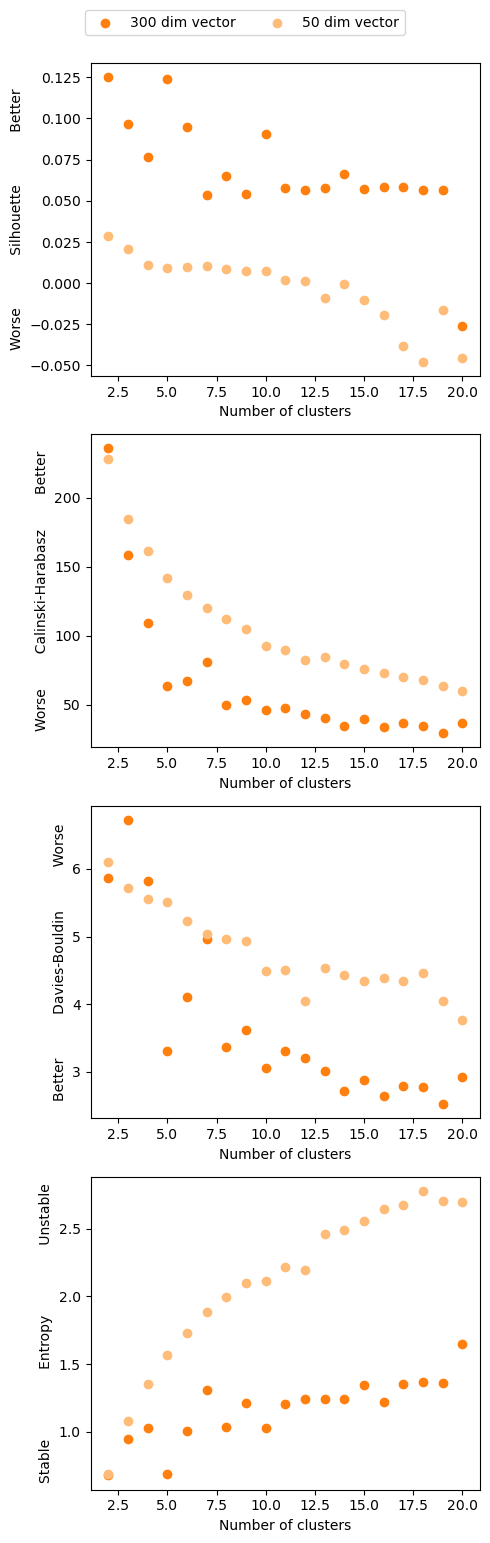

In [7]:
dat = next(iter_dataset)
print(dat)
params = ['n_clusters']
parnam = {params[0]: 'Number of clusters'}
ncols = len(params)
nrows = len(scores)
cmap = mpl.colormaps['tab20']
df_subset = df_kmeans.dropna(how='all', subset=scores)

fig, axes = plt.subplots(nrows, ncols, figsize=(5,15))
col = 0
for row in range(nrows):
# for col in range(ncols): 
    X = df_subset.loc[df_subset['dataset']==dat,:].sort_values(params[col])
    x = X.loc[(X['dimensions']=='300') & (X['distance']=='euclidean'),:]
    axes[row].scatter(data=x, x=params[col], y=scores[row], label=f'300 dim vector', color=cmap.colors[2])
    x = X.loc[(X['dimensions']=='50') & (X['distance']=='euclidean'),:]
    axes[row].scatter(data=x, x=params[col], y=scores[row], label=f'50 dim vector', color=cmap.colors[3])
    # axes[row].set_title(fr'{datasets_names[datasets[col]]}')
    axes[row].set_xlabel(parnam[params[col]])
    axes[row].set_ylabel(score_names[row])
    # if params[col] not in params[1:]:
    #     axes[row].set_xscale('log')
    handles, labels = axes[row].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5,1.03), ncol=4)
fig.savefig(Path(f'../img/scores_kmeans_{dat}.png'), bbox_inches='tight')
plt.show()

chains_ge_4_lt_10


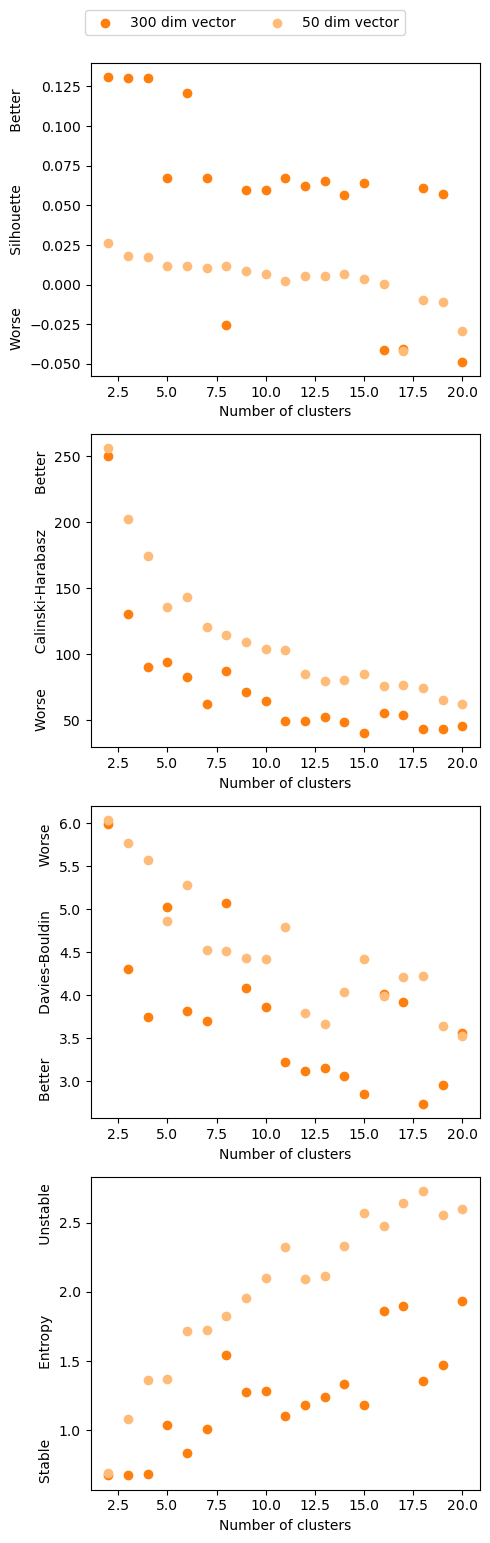

In [8]:
dat = next(iter_dataset)
print(dat)
params = ['n_clusters']
parnam = {params[0]: 'Number of clusters'}
ncols = len(params)
nrows = len(scores)
cmap = mpl.colormaps['tab20']
df_subset = df_kmeans.dropna(how='all', subset=scores)

fig, axes = plt.subplots(nrows, ncols, figsize=(5,15))
col = 0
for row in range(nrows):
# for col in range(ncols): 
    X = df_subset.loc[df_subset['dataset']==dat,:].sort_values(params[col])
    x = X.loc[(X['dimensions']=='300') & (X['distance']=='euclidean'),:]
    axes[row].scatter(data=x, x=params[col], y=scores[row], label=f'300 dim vector', color=cmap.colors[2])
    x = X.loc[(X['dimensions']=='50') & (X['distance']=='euclidean'),:]
    axes[row].scatter(data=x, x=params[col], y=scores[row], label=f'50 dim vector', color=cmap.colors[3])
    # axes[row].set_title(fr'{datasets_names[datasets[col]]}')
    axes[row].set_xlabel(parnam[params[col]])
    axes[row].set_ylabel(score_names[row])
    # if params[col] not in params[1:]:
    #     axes[row].set_xscale('log')
    handles, labels = axes[row].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5,1.03), ncol=4)
fig.savefig(Path(f'../img/scores_kmeans_{dat}.png'), bbox_inches='tight')
plt.show()

chains_ge_10


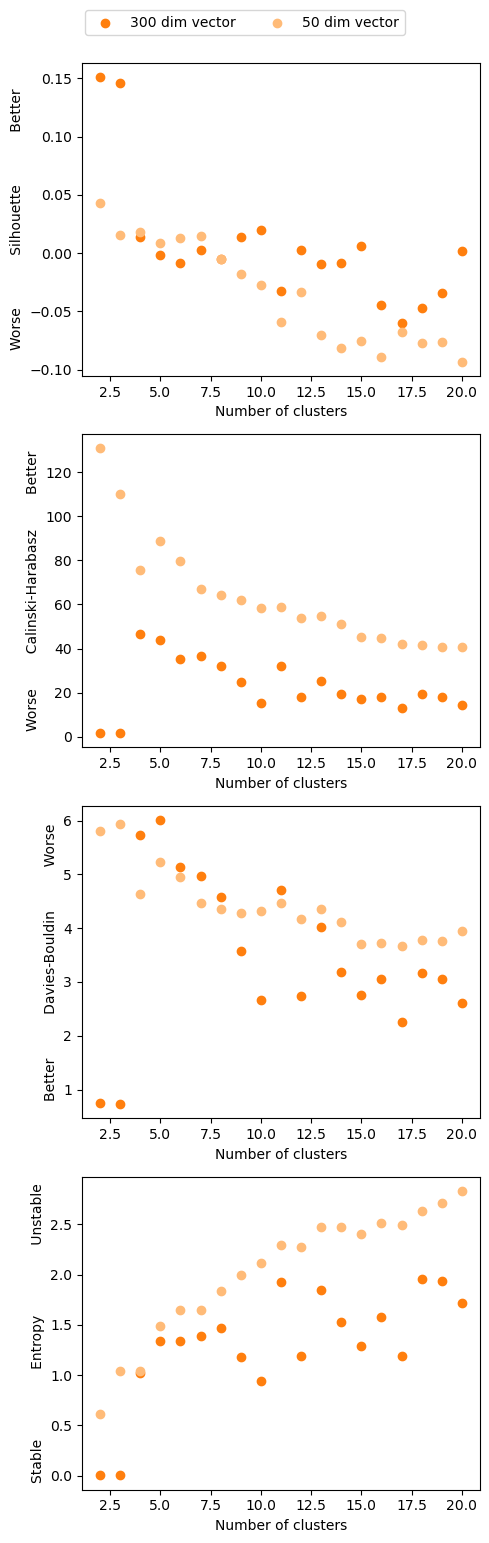

In [9]:
dat = next(iter_dataset)
print(dat)
params = ['n_clusters']
parnam = {params[0]: 'Number of clusters'}
ncols = len(params)
nrows = len(scores)
cmap = mpl.colormaps['tab20']
df_subset = df_kmeans.dropna(how='all', subset=scores)

fig, axes = plt.subplots(nrows, ncols, figsize=(5,15))
col = 0
for row in range(nrows):
# for col in range(ncols): 
    X = df_subset.loc[df_subset['dataset']==dat,:].sort_values(params[col])
    x = X.loc[(X['dimensions']=='300') & (X['distance']=='euclidean'),:]
    axes[row].scatter(data=x, x=params[col], y=scores[row], label=f'300 dim vector', color=cmap.colors[2])
    x = X.loc[(X['dimensions']=='50') & (X['distance']=='euclidean'),:]
    axes[row].scatter(data=x, x=params[col], y=scores[row], label=f'50 dim vector', color=cmap.colors[3])
    # axes[row].set_title(fr'{datasets_names[datasets[col]]}')
    axes[row].set_xlabel(parnam[params[col]])
    axes[row].set_ylabel(score_names[row])
    # if params[col] not in params[1:]:
    #     axes[row].set_xscale('log')
    handles, labels = axes[row].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5,1.03), ncol=4)
fig.savefig(Path(f'../img/scores_kmeans_{dat}.png'), bbox_inches='tight')
plt.show()

# DBSCAN 

In [10]:
df_dbscan

distance       dataset    epsilon  min_pts    nn  n_clusters  sl_score  \
0      cosine   chains_eq_2  17.009451        2   2.0           1       NaN   
4729   cosine   chains_eq_2  13.808106       13  20.0           1       NaN   
4730   cosine   chains_eq_2  13.808106       14  20.0           1       NaN   
4731   cosine   chains_eq_2  13.808106       15  20.0           1       NaN   
4732   cosine   chains_eq_2  13.833861        2  21.0           1       NaN   
...       ...           ...        ...      ...   ...         ...       ...   
7584   cosine  chains_ge_10   5.401439       12  21.0           1       NaN   
7585   cosine  chains_ge_10   5.401439       13  21.0           1       NaN   
7586   cosine  chains_ge_10   5.401439       14  21.0           1       NaN   
7576   cosine  chains_ge_10   5.401439        4  21.0           1       NaN   
5887   cosine  chains_ge_10   4.405619        9  16.0           1       NaN   

      ch_score  db_score  entropy  n_noise   size  prop_noise dimensions  \
0          NaN       NaN      NaN      NaN  23841         NaN        300   
4729       NaN       NaN      NaN      NaN  23841         NaN         50   
4730       NaN       NaN      NaN      NaN  23841         NaN         50   
4731       NaN       NaN      NaN      NaN  23841         NaN         50   
4732       NaN       NaN      NaN      NaN  23841         NaN         50   
...        ...       ...      ...      ...    ...         ...        ...   
7584       NaN       NaN      NaN      NaN   5324         NaN        300   
7585       NaN       NaN      NaN      NaN   5324         NaN        300   
7586       NaN       NaN      NaN      NaN   5324         NaN        300   
7576       NaN       NaN      NaN      NaN   5324         NaN        300   
5887       NaN       NaN      NaN      NaN   5324         NaN         50   

      order          name  k_noise  method  
0         0      CL $= 2$  1 (nan)  DBSCAN  
4729      0      CL $= 2$  1 (nan)  DBSCAN  
4730      0      CL $= 2$  1 (nan)  DBSCAN  
4731      0      CL $= 2$  1 (nan)  DBSCAN  
4732      0      CL $= 2$  1 (nan)  DBSCAN  
...     ...           ...      ...     ...  
7584      3  CL $\geq$ 10  1 (nan)  DBSCAN  
7585      3  CL $\geq$ 10  1 (nan)  DBSCAN  
7586      3  CL $\geq$ 10  1 (nan)  DBSCAN  
7576      3  CL $\geq$ 10  1 (nan)  DBSCAN  
5887      3  CL $\geq$ 10  1 (nan)  DBSCAN  

[9744 rows x 18 columns]

In [11]:
iter_dataset = iter(df_dbscan.sort_values(by='order')['dataset'].unique())

chains_eq_2


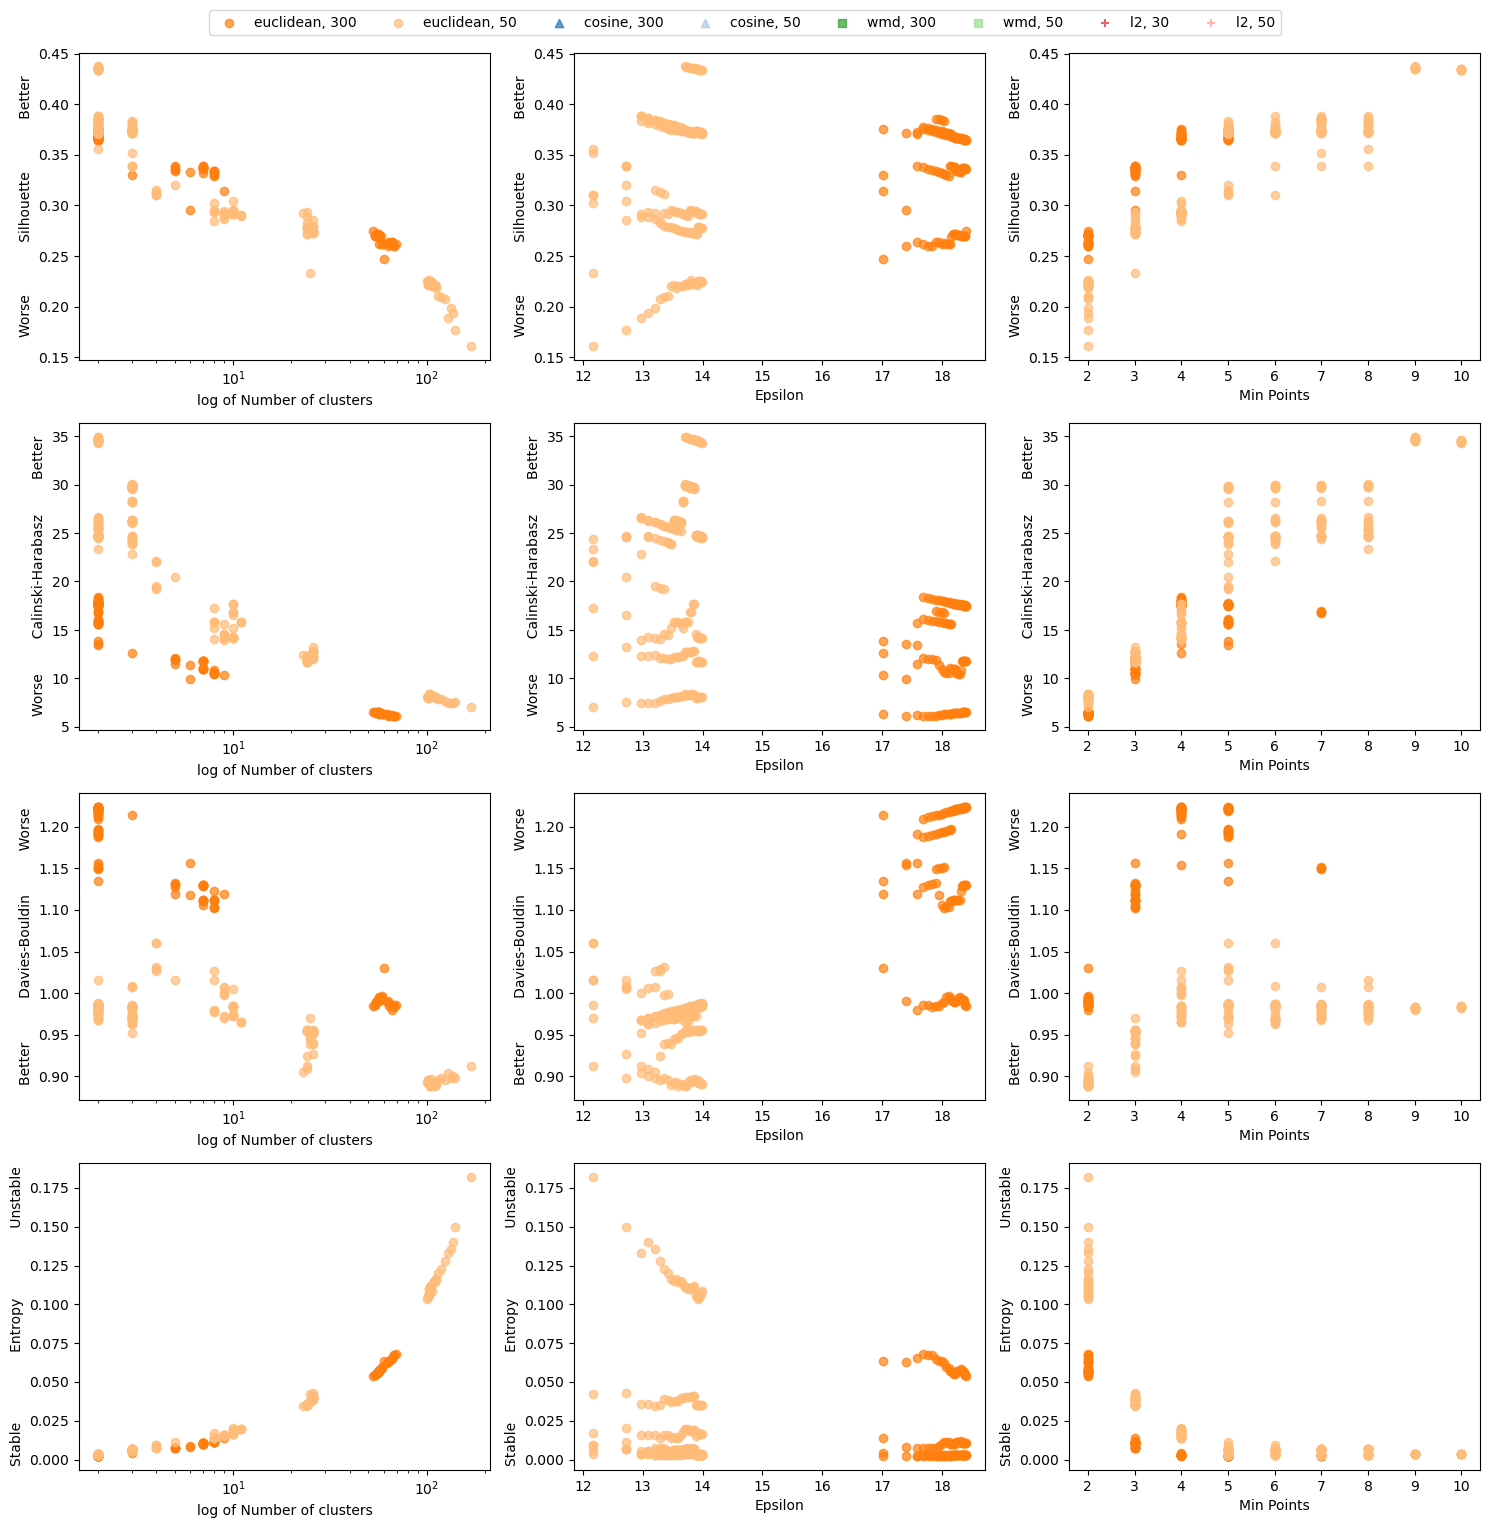

In [12]:
dat = next(iter_dataset)
print(dat)
params = ['n_clusters', 'epsilon', 'min_pts']
parnam = {params[0]: 'Number of clusters', params[1]: 'Epsilon', params[2]: 'Min Points'}
ncols = len(params)
nrows = len(scores)
cmap = mpl.colormaps['tab20']
df_subset = df_dbscan.dropna(how='all', subset=scores)

fig, axes = plt.subplots(nrows, ncols, figsize=(15,15))
for row in range(nrows):
    for col in range(ncols): 
        X = df_subset.loc[df_subset['dataset']==dat,:].sort_values(params[col])
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='euclidean'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'euclidean, 300', color=cmap.colors[2], alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='euclidean'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'euclidean, 50', color=cmap.colors[3], alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='cosine'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'cosine, 300', color=cmap.colors[0], marker='^', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='cosine'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'cosine, 50', color=cmap.colors[1], marker='^', alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='wmd'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'wmd, 300', color=cmap.colors[4], marker='s', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='wmd'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'wmd, 50', color=cmap.colors[5], marker='s', alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='l2'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'l2, 30', color=cmap.colors[6], marker='+', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='l2'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'l2, 50', color=cmap.colors[7], marker='+', alpha=0.7)
        # axes[row][col].set_title(fr'{datasets_names[datasets[col]]}')
        
        axes[row][col].set_ylabel(score_names[row])
        if params[col] not in params[1:]:
            axes[row][col].set_xscale('log')
            axes[row][col].set_xlabel('log of ' + parnam[params[col]])
        else:
            axes[row][col].set_xlabel(parnam[params[col]])
        handles, labels = axes[row][col].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5,1.02), ncol=8)
fig.savefig(Path(f'../img/scores_dbscan_{dat}.png'), bbox_inches='tight')
plt.show()

chains_eq_3


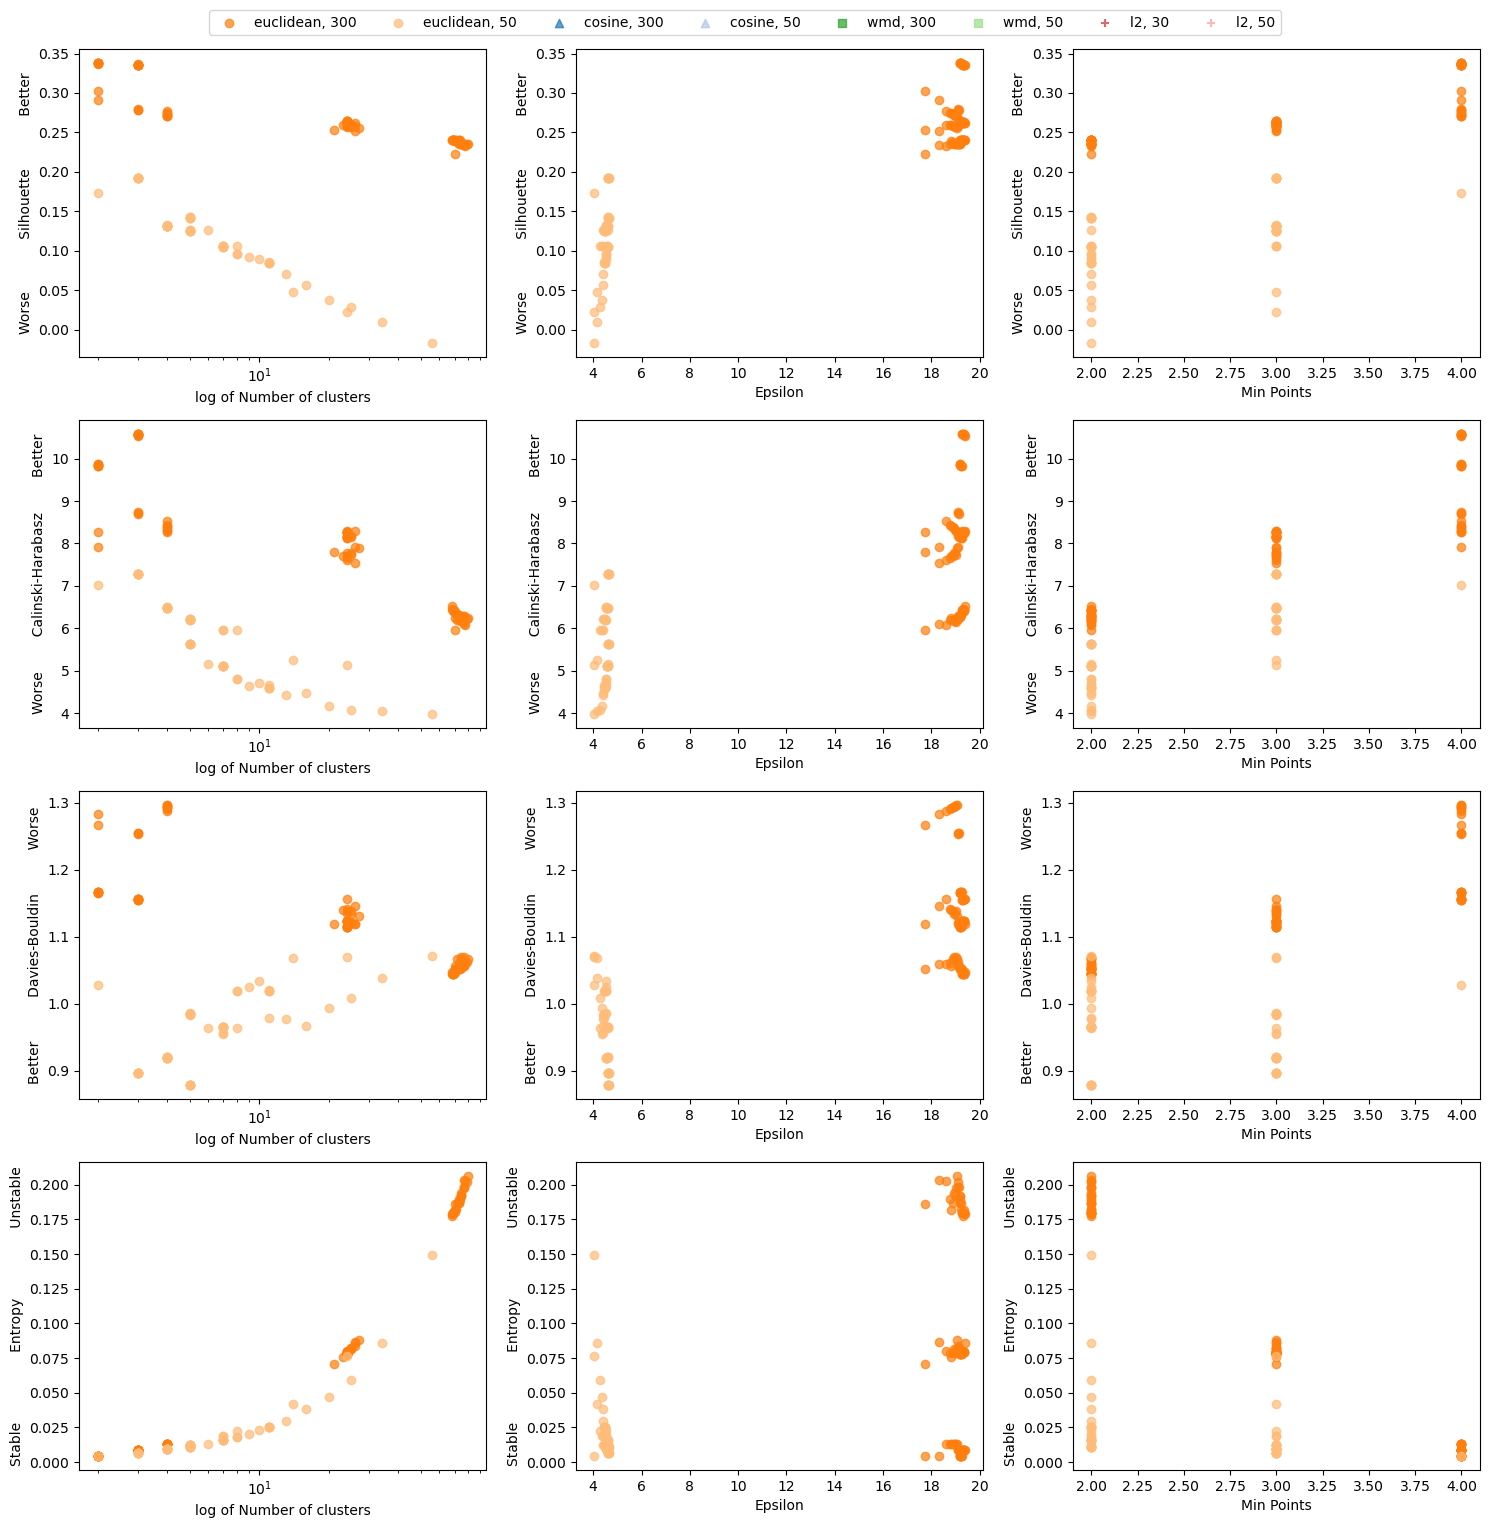

In [13]:
dat = next(iter_dataset)
print(dat)
params = ['n_clusters', 'epsilon', 'min_pts']
parnam = {params[0]: 'Number of clusters', params[1]: 'Epsilon', params[2]: 'Min Points'}
ncols = len(params)
nrows = len(scores)
cmap = mpl.colormaps['tab20']

fig, axes = plt.subplots(nrows, ncols, figsize=(15,15))
for row in range(nrows):
    for col in range(ncols): 
        X = df_dbscan.dropna(how='all', subset=scores).loc[df_dbscan['dataset']==dat,:].sort_values(params[col])
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='euclidean'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'euclidean, 300', color=cmap.colors[2], alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='euclidean'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'euclidean, 50', color=cmap.colors[3], alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='cosine'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'cosine, 300', color=cmap.colors[0], marker='^', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='cosine'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'cosine, 50', color=cmap.colors[1], marker='^', alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='wmd'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'wmd, 300', color=cmap.colors[4], marker='s', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='wmd'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'wmd, 50', color=cmap.colors[5], marker='s', alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='l2'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'l2, 30', color=cmap.colors[6], marker='+', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='l2'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'l2, 50', color=cmap.colors[7], marker='+', alpha=0.7)
        # axes[row][col].set_title(fr'{datasets_names[datasets[col]]}')
        
        axes[row][col].set_ylabel(score_names[row])
        if params[col] not in params[1:]:
            axes[row][col].set_xscale('log')
            axes[row][col].set_xlabel('log of ' + parnam[params[col]])
        else:
            axes[row][col].set_xlabel(parnam[params[col]])
        handles, labels = axes[row][col].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5,1.02), ncol=8)
fig.savefig(Path(f'../img/scores_dbscan_{dat}.png'), bbox_inches='tight')
plt.show()

chains_ge_4_lt_10


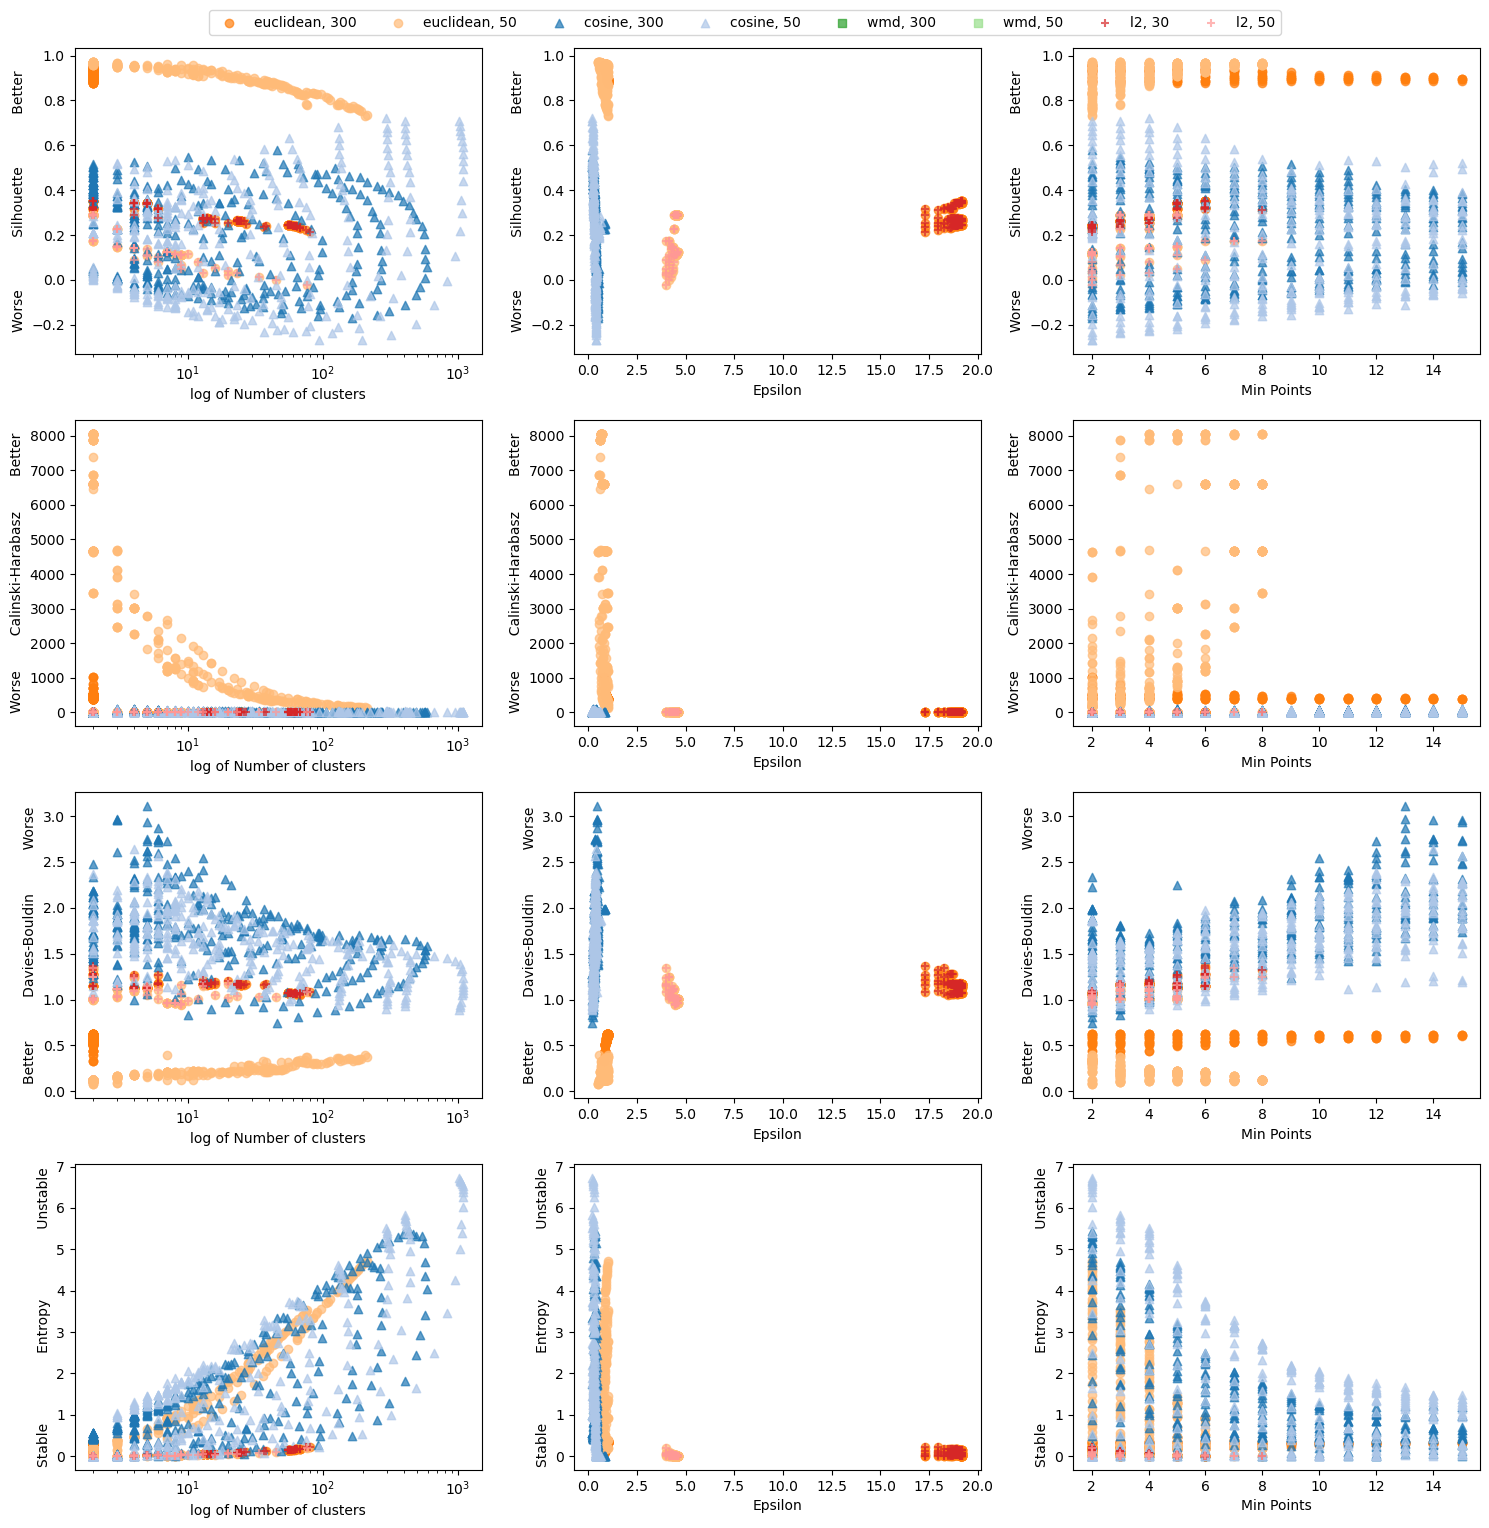

In [30]:
dat = next(iter_dataset)
print(dat)
params = ['n_clusters', 'epsilon', 'min_pts']
parnam = {params[0]: 'Number of clusters', params[1]: 'Epsilon', params[2]: 'Min Points'}
ncols = len(params)
nrows = len(scores)
cmap = mpl.colormaps['tab20']

fig, axes = plt.subplots(nrows, ncols, figsize=(15,15))
for row in range(nrows):
    for col in range(ncols): 
        X = df_dbscan.dropna(how='all', subset=scores).loc[df_dbscan['dataset']==dat,:].sort_values(params[col])
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='euclidean'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'euclidean, 300', color=cmap.colors[2], alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='euclidean'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'euclidean, 50', color=cmap.colors[3], alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='cosine'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'cosine, 300', color=cmap.colors[0], marker='^', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='cosine'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'cosine, 50', color=cmap.colors[1], marker='^', alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='wmd'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'wmd, 300', color=cmap.colors[4], marker='s', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='wmd'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'wmd, 50', color=cmap.colors[5], marker='s', alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='l2'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'l2, 30', color=cmap.colors[6], marker='+', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='l2'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'l2, 50', color=cmap.colors[7], marker='+', alpha=0.7)
        # axes[row][col].set_title(fr'{datasets_names[datasets[col]]}')
        
        axes[row][col].set_ylabel(score_names[row])
        if params[col] not in params[1:]:
            axes[row][col].set_xscale('log')
            axes[row][col].set_xlabel('log of ' + parnam[params[col]])
        else:
            axes[row][col].set_xlabel(parnam[params[col]])
        handles, labels = axes[row][col].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5,1.02), ncol=8)
fig.savefig(Path(f'../img/scores_dbscan_{dat}.png'), bbox_inches='tight')
plt.show()

chains_ge_10


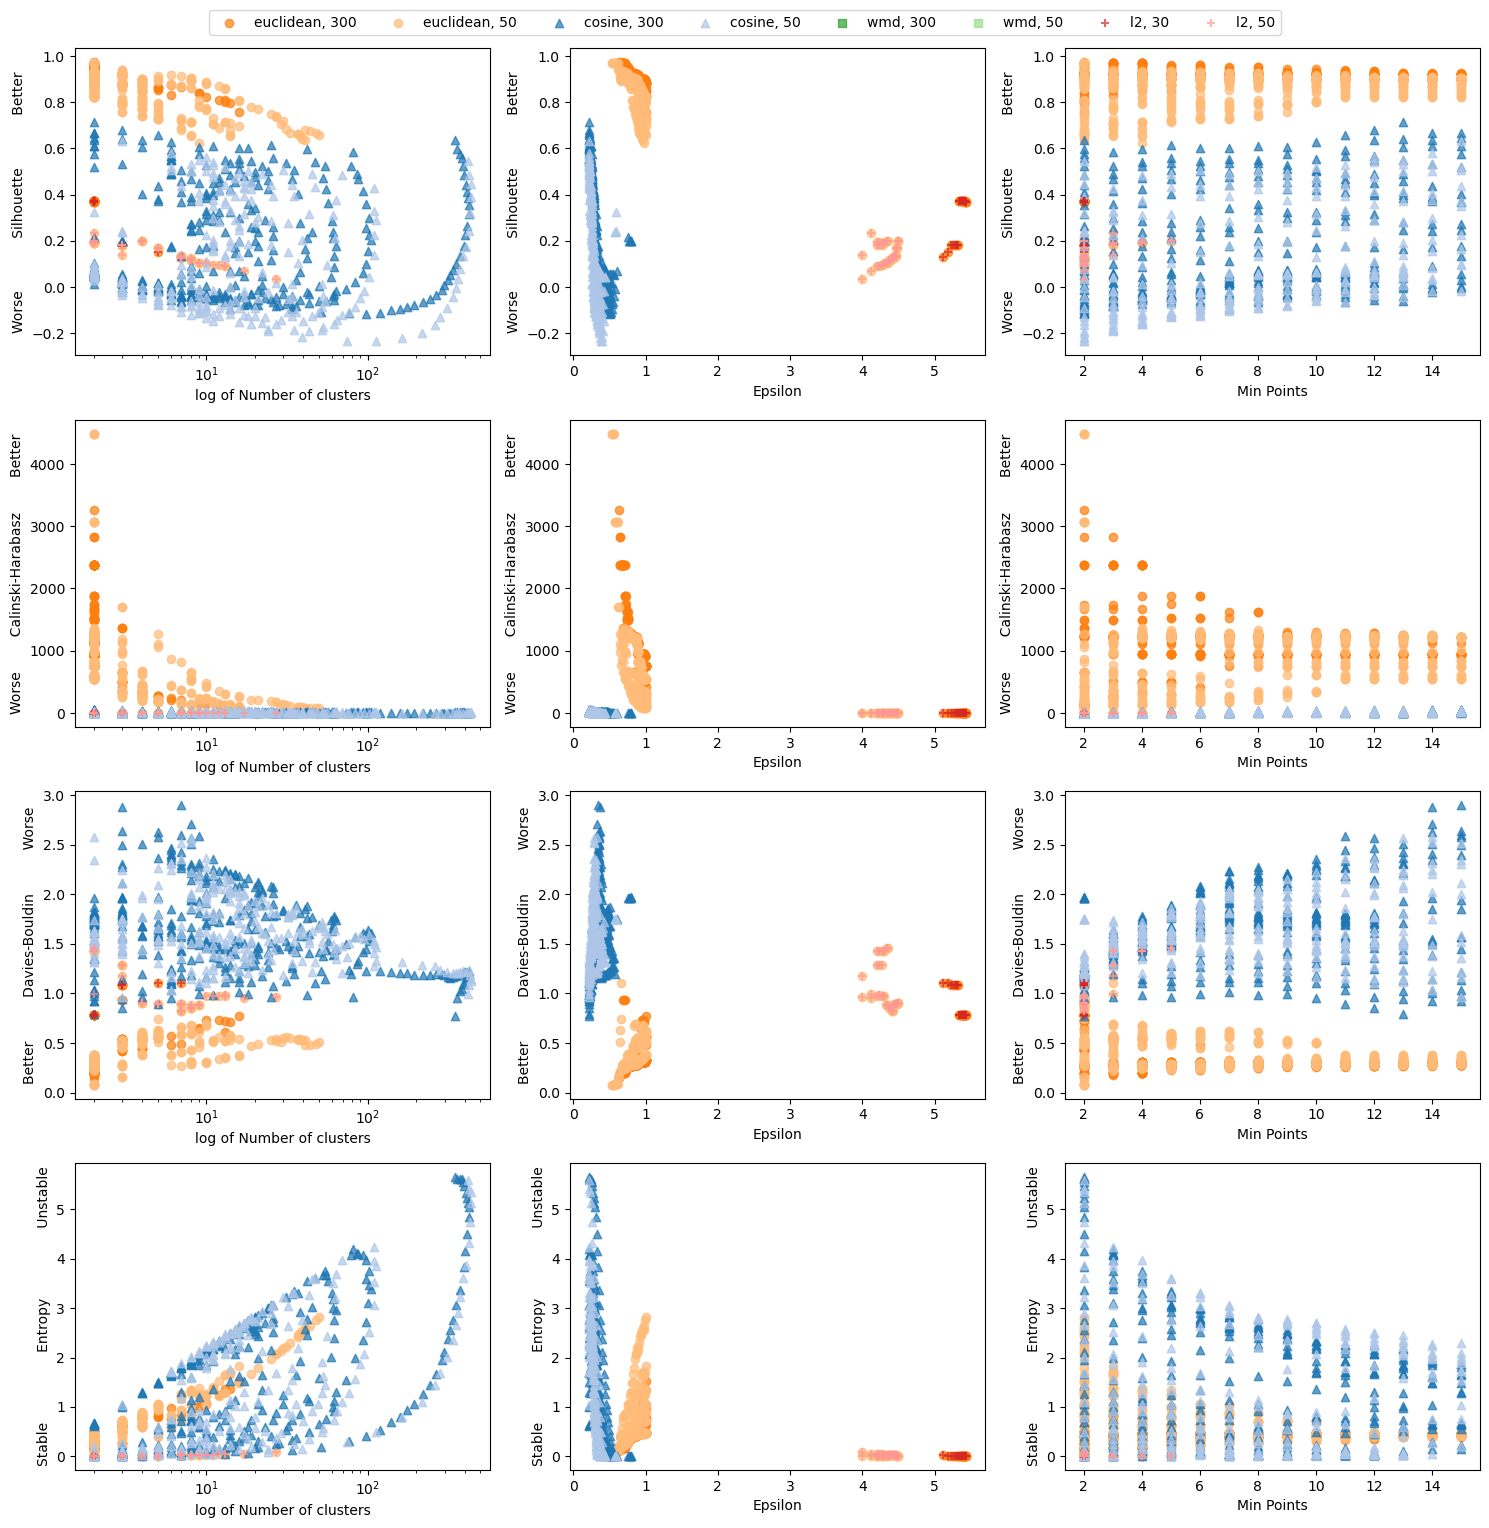

In [31]:
dat = next(iter_dataset)
print(dat)
params = ['n_clusters', 'epsilon', 'min_pts']
parnam = {params[0]: 'Number of clusters', params[1]: 'Epsilon', params[2]: 'Min Points'}
ncols = len(params)
nrows = len(scores)
cmap = mpl.colormaps['tab20']

fig, axes = plt.subplots(nrows, ncols, figsize=(15,15))
for row in range(nrows):
    for col in range(ncols): 
        X = df_dbscan.dropna(how='all', subset=scores).loc[df_dbscan['dataset']==dat,:].sort_values(params[col])
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='euclidean'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'euclidean, 300', color=cmap.colors[2], alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='euclidean'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'euclidean, 50', color=cmap.colors[3], alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='cosine'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'cosine, 300', color=cmap.colors[0], marker='^', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='cosine'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'cosine, 50', color=cmap.colors[1], marker='^', alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='wmd'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'wmd, 300', color=cmap.colors[4], marker='s', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='wmd'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'wmd, 50', color=cmap.colors[5], marker='s', alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='l2'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'l2, 30', color=cmap.colors[6], marker='+', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='l2'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'l2, 50', color=cmap.colors[7], marker='+', alpha=0.7)
        # axes[row][col].set_title(fr'{datasets_names[datasets[col]]}')
        
        axes[row][col].set_ylabel(score_names[row])
        if params[col] not in params[1:]:
            axes[row][col].set_xscale('log')
            axes[row][col].set_xlabel('log of ' + parnam[params[col]])
        else:
            axes[row][col].set_xlabel(parnam[params[col]])
        handles, labels = axes[row][col].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5,1.02), ncol=8)
fig.savefig(Path(f'../img/scores_dbscan_{dat}.png'), bbox_inches='tight')
plt.show()

# HDBSCAN

In [16]:
df_hdbscan.sort_values(by='order')['dataset'].unique()

array(['chains_eq_2', 'chains_eq_3', 'chains_ge_4_lt_10', 'chains_ge_10'],
      dtype=object)

In [22]:
iter_dataset = iter(df_hdbscan.sort_values(by='order')['dataset'].unique())

chains_eq_2


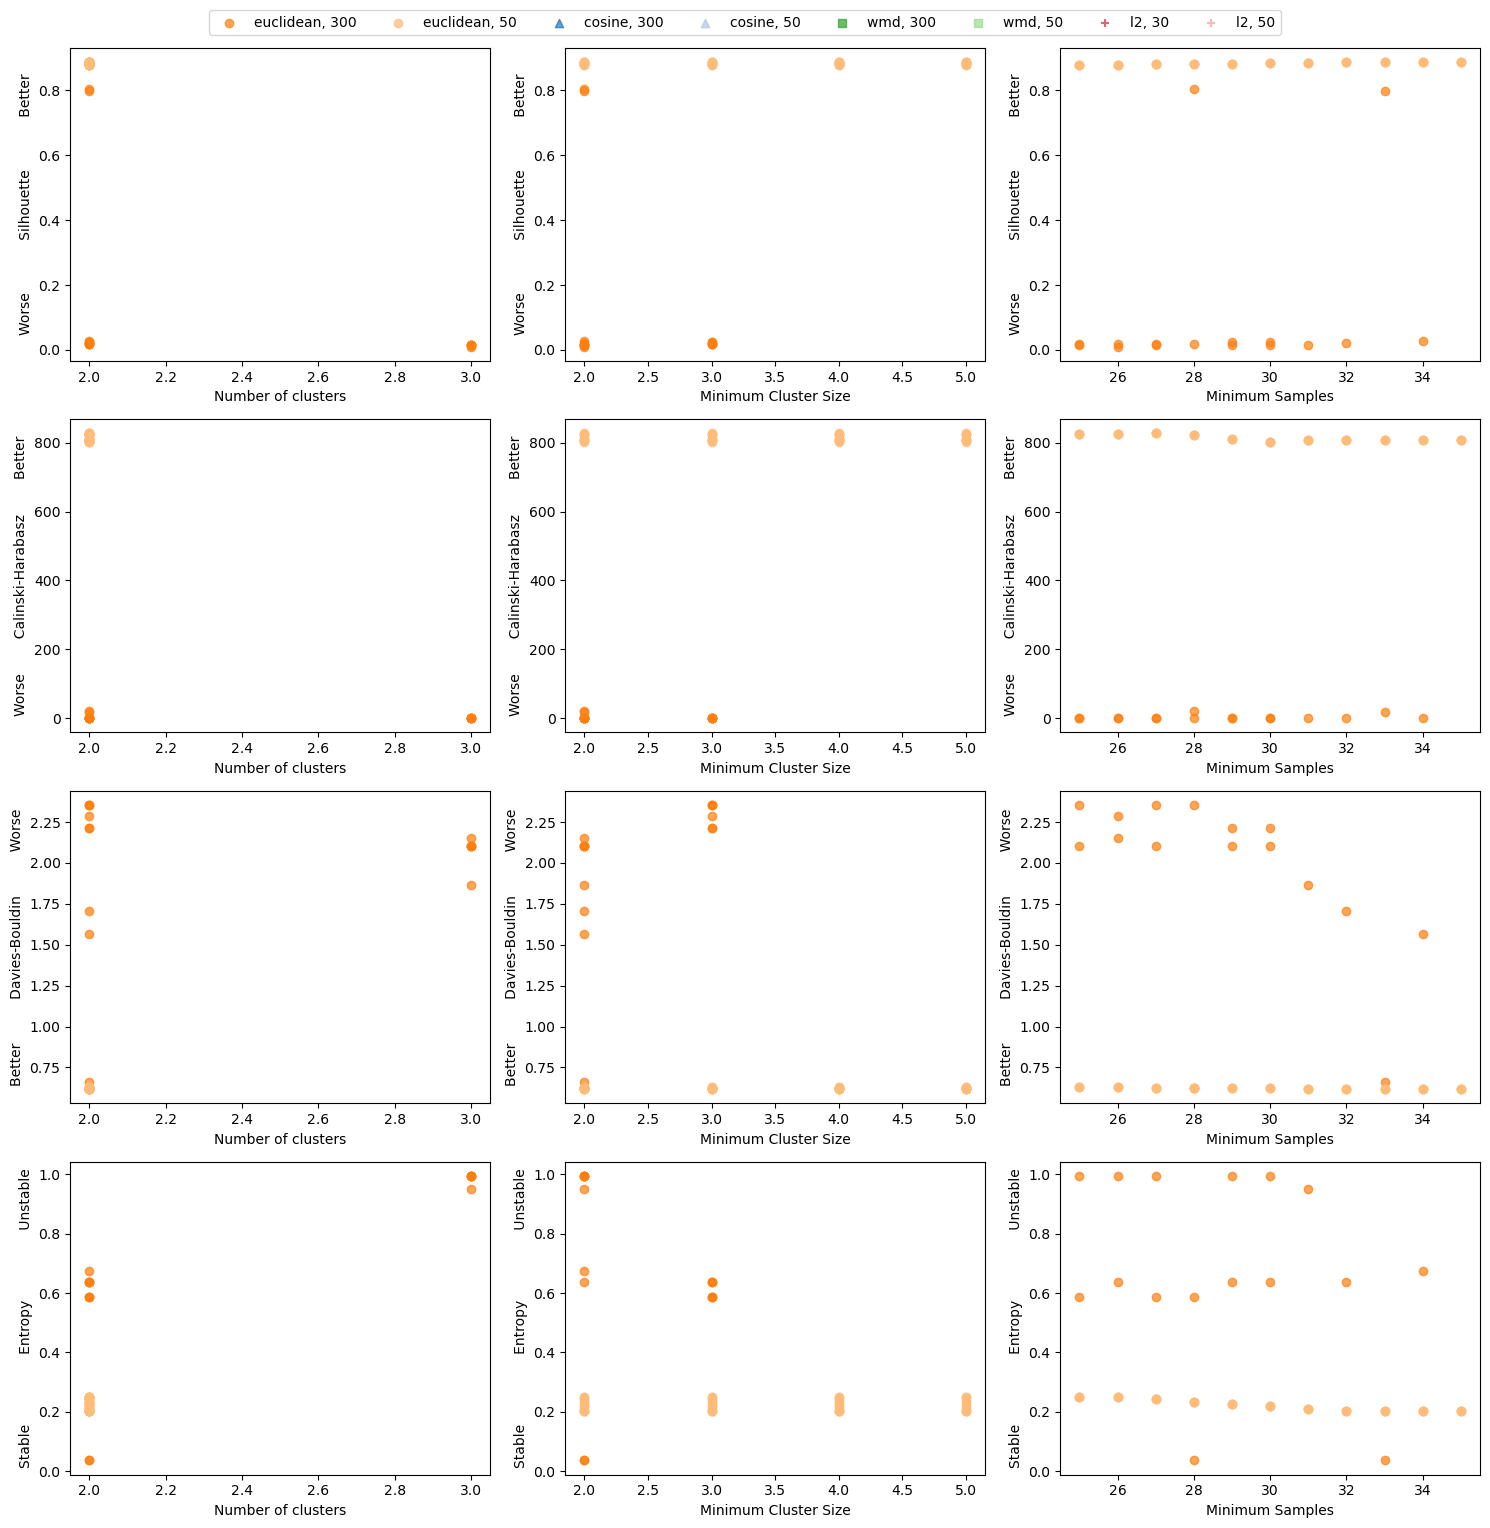

In [23]:
dat = next(iter_dataset)
print(dat)
df_subset = df_hdbscan.dropna(how='all', subset=scores)
params = ['n_clusters', 'min_clt_size', 'min_samples']
parnam = {params[0]: 'Number of clusters', params[1]: 'Minimum Cluster Size', params[2]: 'Minimum Samples'}
ncols = len(params)
nrows = len(scores)
cmap = mpl.colormaps['tab20']

fig, axes = plt.subplots(nrows, ncols, figsize=(15,15))
for row in range(nrows):
    for col in range(ncols):
        X = df_subset.loc[df_hdbscan['dataset']==dat,:].sort_values(params[col])
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='euclidean'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'euclidean, 300', color=cmap.colors[2], alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='euclidean'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'euclidean, 50', color=cmap.colors[3], alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='cosine'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'cosine, 300', color=cmap.colors[0], marker='^', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='cosine'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'cosine, 50', color=cmap.colors[1], marker='^', alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='wmd'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'wmd, 300', color=cmap.colors[4], marker='s', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='wmd'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'wmd, 50', color=cmap.colors[5], marker='s', alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='l2'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'l2, 30', color=cmap.colors[6], marker='+', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='l2'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'l2, 50', color=cmap.colors[7], marker='+', alpha=0.7)
        # axes[row][col].set_title(fr'{datasets_names[datasets[col]]}')
        axes[row][col].set_xlabel(parnam[params[col]])
        axes[row][col].set_ylabel(score_names[row])
        # if params[col] not in params[1:]:
            # axes[row][col].set_xscale('log')
        handles, labels = axes[row][col].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5,1.02), ncol=8)
fig.savefig(Path(f'../img/scores_hdbscan_{dat}.png'), bbox_inches='tight')
plt.show()

chains_eq_3


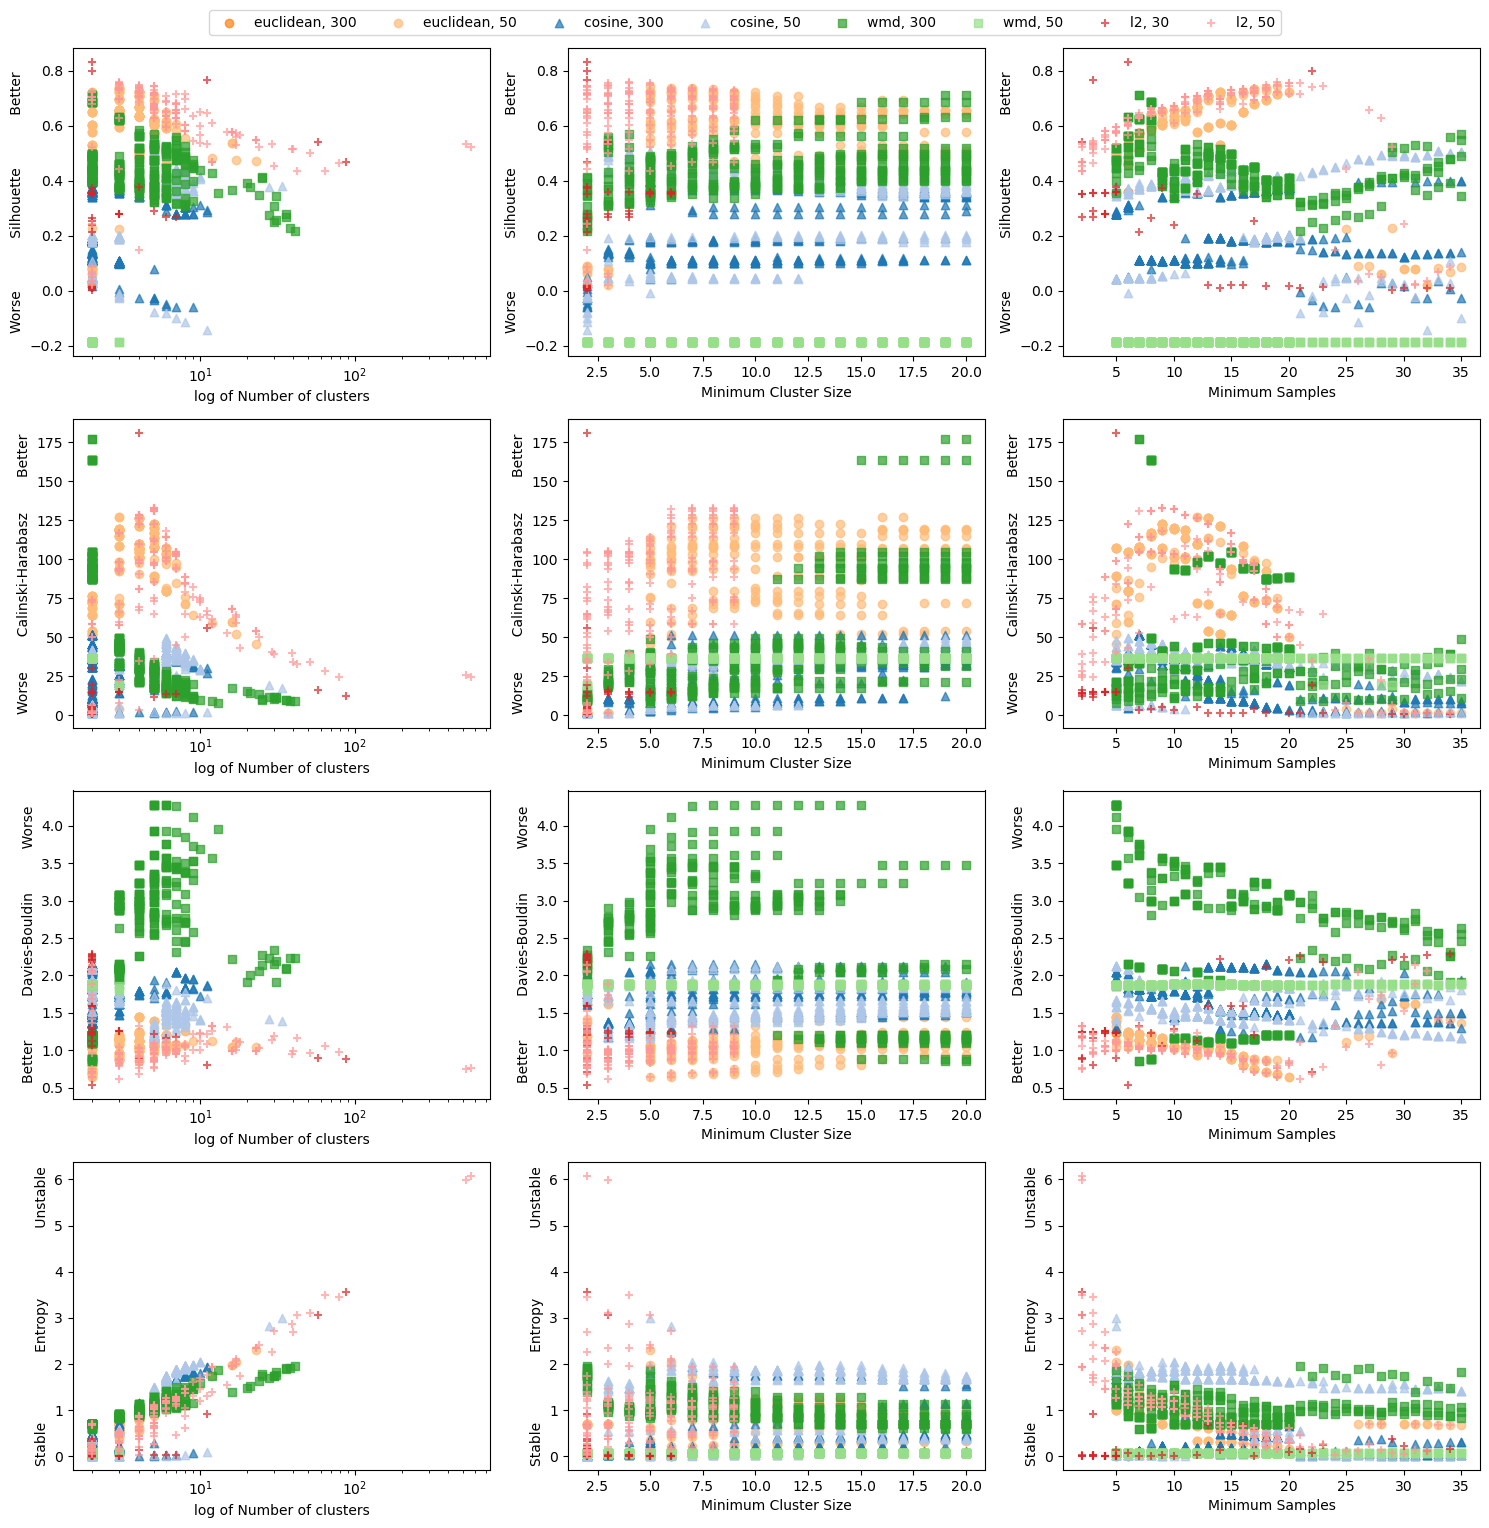

In [24]:
dat = next(iter_dataset)
print(dat)
df_subset = df_hdbscan.dropna(how='all', subset=scores)
params = ['n_clusters', 'min_clt_size', 'min_samples']
parnam = {params[0]: 'Number of clusters', params[1]: 'Minimum Cluster Size', params[2]: 'Minimum Samples'}
ncols = len(params)
nrows = len(scores)
cmap = mpl.colormaps['tab20']

fig, axes = plt.subplots(nrows, ncols, figsize=(15,15))
for row in range(nrows):
    for col in range(ncols):
        X = df_subset.loc[df_hdbscan['dataset']==dat,:].sort_values(params[col])
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='euclidean'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'euclidean, 300', color=cmap.colors[2], alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='euclidean'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'euclidean, 50', color=cmap.colors[3], alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='cosine'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'cosine, 300', color=cmap.colors[0], marker='^', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='cosine'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'cosine, 50', color=cmap.colors[1], marker='^', alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='wmd'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'wmd, 300', color=cmap.colors[4], marker='s', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='wmd'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'wmd, 50', color=cmap.colors[5], marker='s', alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='l2'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'l2, 30', color=cmap.colors[6], marker='+', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='l2'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'l2, 50', color=cmap.colors[7], marker='+', alpha=0.7)
        # axes[row][col].set_title(fr'{datasets_names[datasets[col]]}')
        
        axes[row][col].set_ylabel(score_names[row])
        if params[col] not in params[1:]:
            axes[row][col].set_xscale('log')
            axes[row][col].set_xlabel('log of ' + parnam[params[col]])
        else:
            axes[row][col].set_xlabel(parnam[params[col]])
        handles, labels = axes[row][col].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5,1.02), ncol=8)
fig.savefig(Path(f'../img/scores_hdbscan_{dat}.png'), bbox_inches='tight')
plt.show()

chains_ge_4_lt_10


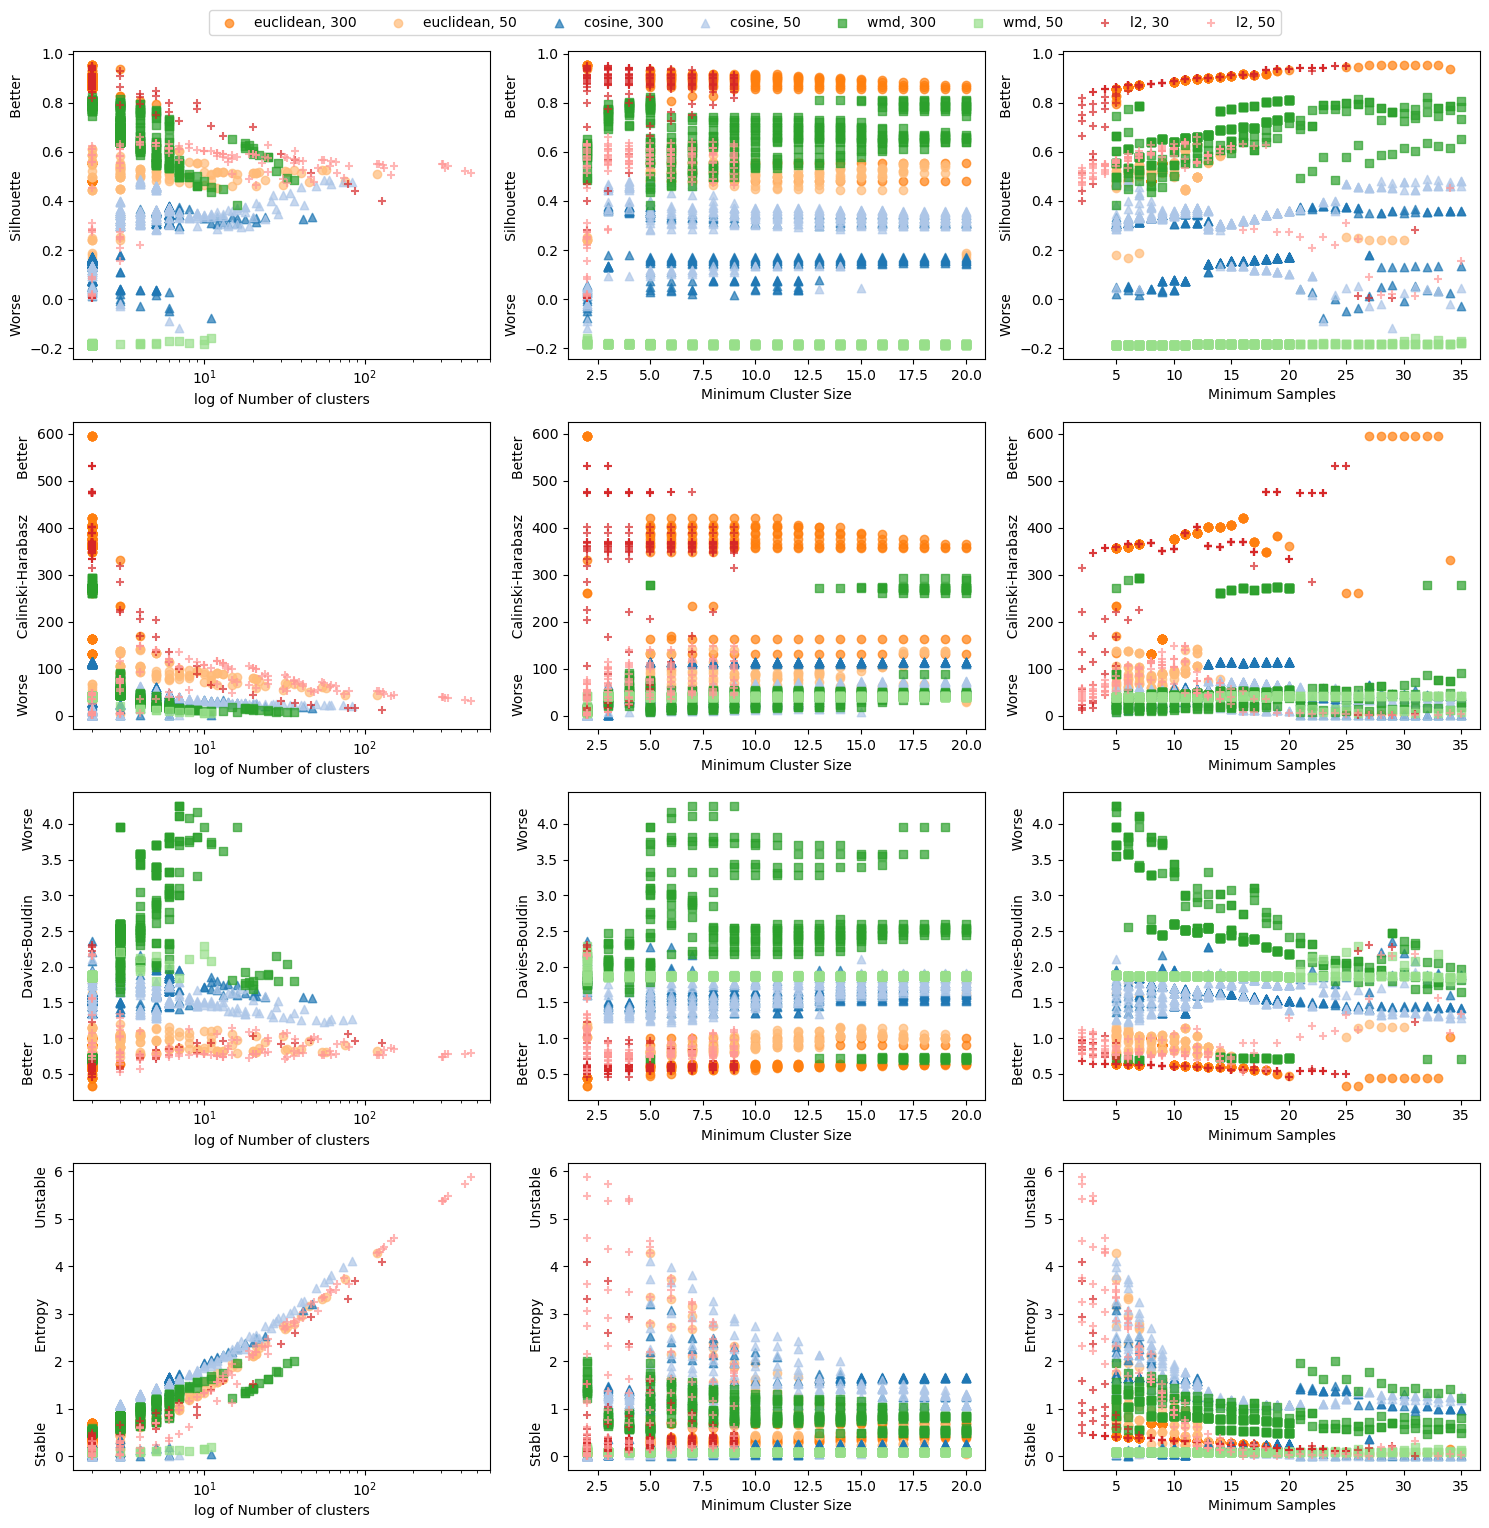

In [25]:
dat = next(iter_dataset)
print(dat)
df_subset = df_hdbscan.dropna(how='all', subset=scores)
params = ['n_clusters', 'min_clt_size', 'min_samples']
parnam = {params[0]: 'Number of clusters', params[1]: 'Minimum Cluster Size', params[2]: 'Minimum Samples'}
ncols = len(params)
nrows = len(scores)
cmap = mpl.colormaps['tab20']

fig, axes = plt.subplots(nrows, ncols, figsize=(15,15))
for row in range(nrows):
    for col in range(ncols):
        X = df_subset.loc[df_hdbscan['dataset']==dat,:].sort_values(params[col])
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='euclidean'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'euclidean, 300', color=cmap.colors[2], alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='euclidean'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'euclidean, 50', color=cmap.colors[3], alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='cosine'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'cosine, 300', color=cmap.colors[0], marker='^', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='cosine'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'cosine, 50', color=cmap.colors[1], marker='^', alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='wmd'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'wmd, 300', color=cmap.colors[4], marker='s', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='wmd'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'wmd, 50', color=cmap.colors[5], marker='s', alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='l2'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'l2, 30', color=cmap.colors[6], marker='+', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='l2'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'l2, 50', color=cmap.colors[7], marker='+', alpha=0.7)
        # axes[row][col].set_title(fr'{datasets_names[datasets[col]]}')
        
        axes[row][col].set_ylabel(score_names[row])
        if params[col] not in params[1:]:
            axes[row][col].set_xscale('log')
            axes[row][col].set_xlabel('log of ' + parnam[params[col]])
        else:
            axes[row][col].set_xlabel(parnam[params[col]])
        handles, labels = axes[row][col].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5,1.02), ncol=8)
fig.savefig(Path(f'../img/scores_hdbscan_{dat}.png'), bbox_inches='tight')
plt.show()

chains_ge_10


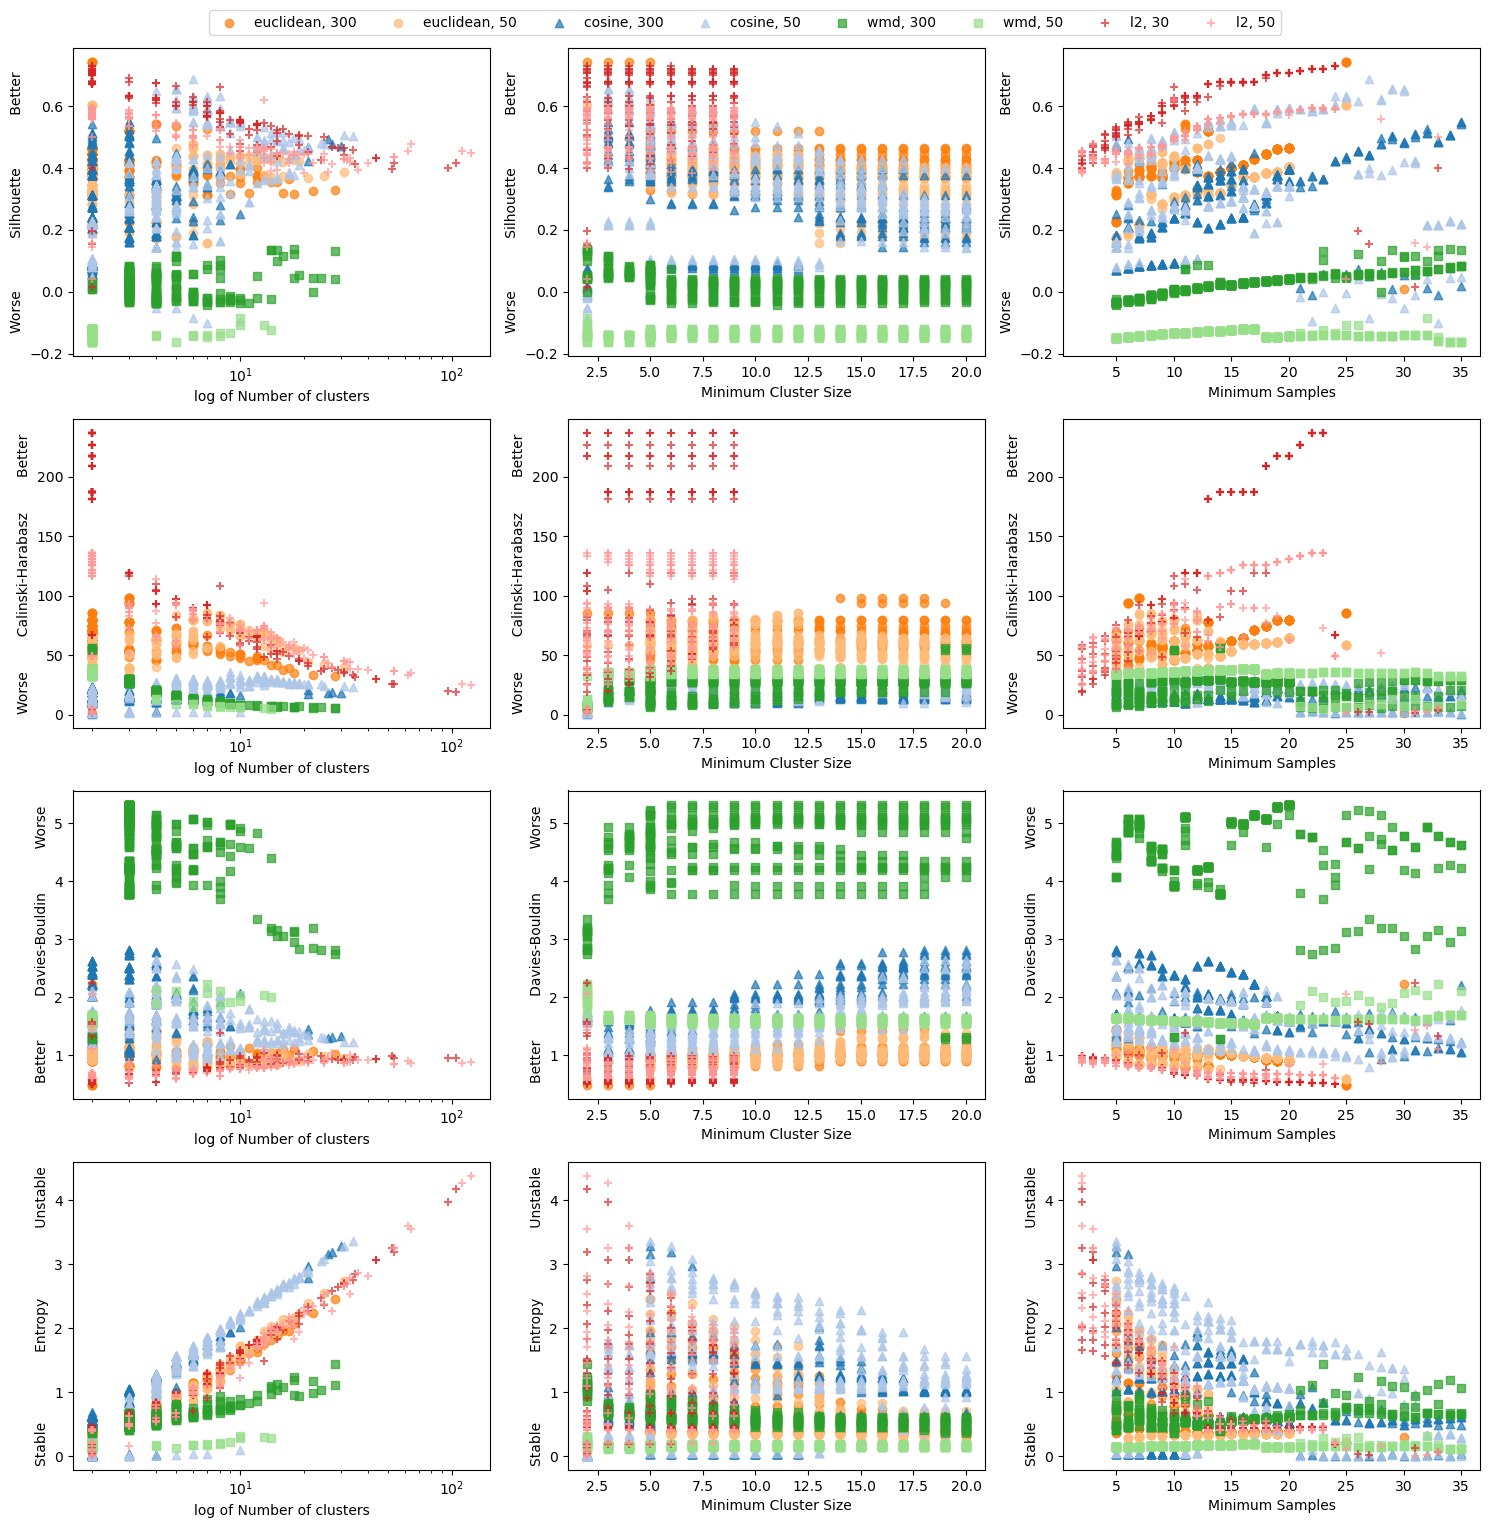

In [26]:
dat = next(iter_dataset)
print(dat)
df_subset = df_hdbscan.dropna(how='all', subset=scores)
params = ['n_clusters', 'min_clt_size', 'min_samples']
parnam = {params[0]: 'Number of clusters', params[1]: 'Minimum Cluster Size', params[2]: 'Minimum Samples'}
ncols = len(params)
nrows = len(scores)
cmap = mpl.colormaps['tab20']

fig, axes = plt.subplots(nrows, ncols, figsize=(15,15))
for row in range(nrows):
    for col in range(ncols):
        X = df_subset.loc[df_hdbscan['dataset']==dat,:].sort_values(params[col])
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='euclidean'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'euclidean, 300', color=cmap.colors[2], alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='euclidean'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'euclidean, 50', color=cmap.colors[3], alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='cosine'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'cosine, 300', color=cmap.colors[0], marker='^', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='cosine'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'cosine, 50', color=cmap.colors[1], marker='^', alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='wmd'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'wmd, 300', color=cmap.colors[4], marker='s', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='wmd'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'wmd, 50', color=cmap.colors[5], marker='s', alpha=0.7)
        x = X.loc[(X['dimensions']=='300') & (X['distance']=='l2'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'l2, 30', color=cmap.colors[6], marker='+', alpha=0.7)
        x = X.loc[(X['dimensions']=='50') & (X['distance']=='l2'),:]
        axes[row][col].scatter(data=x, x=params[col], y=scores[row], label=f'l2, 50', color=cmap.colors[7], marker='+', alpha=0.7)
        # axes[row][col].set_title(fr'{datasets_names[datasets[col]]}')
        
        axes[row][col].set_ylabel(score_names[row])
        if params[col] not in params[1:]:
            axes[row][col].set_xscale('log')
            axes[row][col].set_xlabel('log of ' + parnam[params[col]])
        else:
            axes[row][col].set_xlabel(parnam[params[col]])
        handles, labels = axes[row][col].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5,1.02), ncol=8)
fig.savefig(Path(f'../img/scores_hdbscan_{dat}.png'), bbox_inches='tight')
plt.show()